In [1]:
import os

# do not prealocate memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_theme(context='paper', style='white', font_scale=1.6, color_codes=True)

In [3]:
import jax.numpy as jnp
import equinox as eqx
from copy import deepcopy
from math import prod
from jax import random, nn, vmap, devices, device_put

from bmr4pml.models import SVIRegression, BMRRegression
from bmr4pml.nn import MLP, LeNet
from bmr4pml.datasets import load_data
from bmr4pml.inference import fit_and_test

rng_key = random.PRNGKey(0)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
def standardize(train_images, test_images, num_channels=1):
    mean = train_images.reshape(-1, num_channels).mean(0)
    std = train_images.reshape(-1, num_channels).std(0)

    return (train_images - mean) / std, (test_images - mean) / std

def run_inference(rng_key, nnet, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression):

    reg = reg_model(
        nnet,
        **opts_regression
    )

    rng_key, opts_fitting['key'] = random.split(rng_key)
    return fit_and_test(reg, train_ds, test_ds, opts_fitting)

def plot_performance(results, num_epochs):
    fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=True)

    for key in results:
        vals = results[key]
        if vals is not None:
            for ax, lbl in zip(axes, ['acc', 'ece', 'nll']):
                ax.plot(range(1, num_epochs + 1), vals[lbl], 'o:', label=key)
                ax.set_xlabel('epoch')
                ax.set_title(lbl)

    axes[0].legend(title='method', fontsize=12)
    axes[0].set_ylim([.95, 1.])
    fig.tight_layout()

    return fig

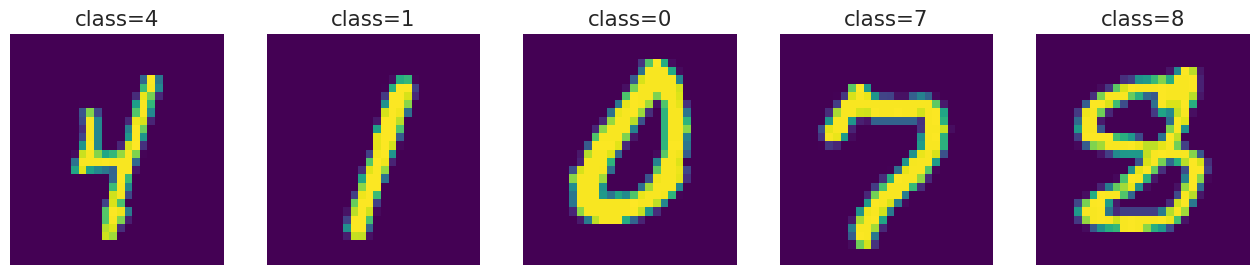

In [5]:
# load data
train_ds, test_ds = load_data('mnist', id=0)

in_size = train_ds['image'].shape[-3:]
out_size = len(jnp.unique(train_ds['label']))

fig, axes = plt.subplots(1, 5, figsize=(16, 3), sharex=True, sharey=True)
for n in range(5):
    sns.heatmap(
        train_ds['image'][n].squeeze() / 255, 
        cmap='viridis', 
        ax = axes[n], 
        cbar=False, 
        vmax=1., 
        vmin=0.,
        xticklabels="",
        yticklabels=""
    )
    axes[n].set_title('class={}'.format(train_ds['label'][n]))

train_ds['image'], test_ds['image'] = standardize(train_ds['image'], test_ds['image'], num_channels=1)

# DenseNet

In [6]:
depth = 3
num_neurons = 100
num_epochs = 10
num_iters = 1_000

cpu = devices('cpu')[0]
results = {'dense': {}, 'lenet': {}}

In [7]:
opts_regression = {
    'regtype': 'multinomial',
    'gamma0': 0.1,
    'autoguide': 'delta',
    'optim_kwargs': {
        'learning_rate': 1e-2
    }
}

opts_fitting = {
    'num_epochs': num_epochs,
    'num_iters': num_iters,
    'num_samples': 1,
    'model_kwargs': {
        'batch_size': 128, 
        'with_hyperprior': False,
    }
}

rng_key, key = random.split(rng_key)
nnet = MLP( prod(in_size), out_size, num_neurons, depth, activation=nn.swish, dropout_rate=0.2, key=key)

100%|██████████| 10/10 [00:31<00:00,  3.15s/it, init loss: 240071.4688, avg. loss [epoch 10]: 101200.2500]


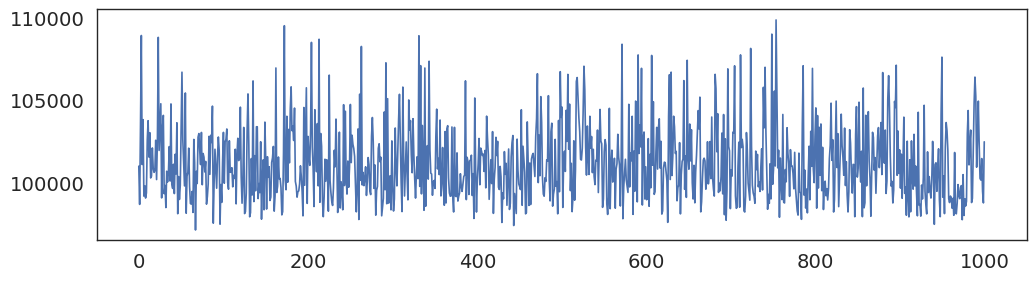

In [41]:
rng_key, key = random.split(rng_key)
output = run_inference(key, nnet, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
results['dense']['Flat-MAP'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

100%|██████████| 10/10 [01:51<00:00, 11.14s/it, init loss: 1914202.1250, avg. loss [epoch 10]: 23461.3848]


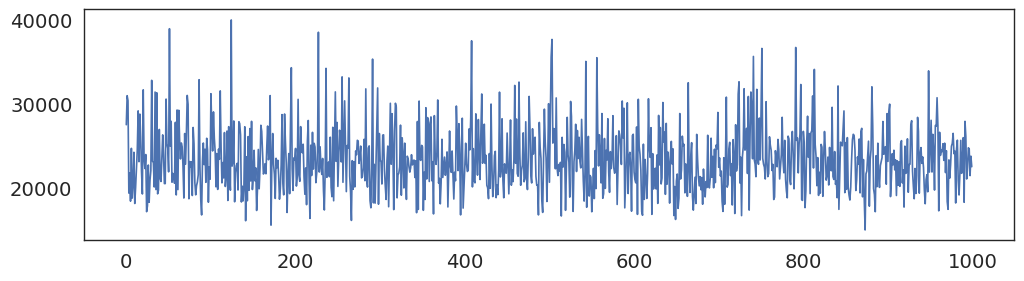

In [42]:
opts_regression = opts_regression | {'autoguide': 'mean-field'}
opts_fitting = opts_fitting | {'num_samples': 100}

dense = eqx.tree_inference(nnet, value=True)

rng_key, key = random.split(rng_key)
output = run_inference(key, dense, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
results['dense']['Flat-FF'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

100%|██████████| 10/10 [03:16<00:00, 19.67s/it, init loss: 431053.4688, avg. loss [epoch 10]: 18874.5293]


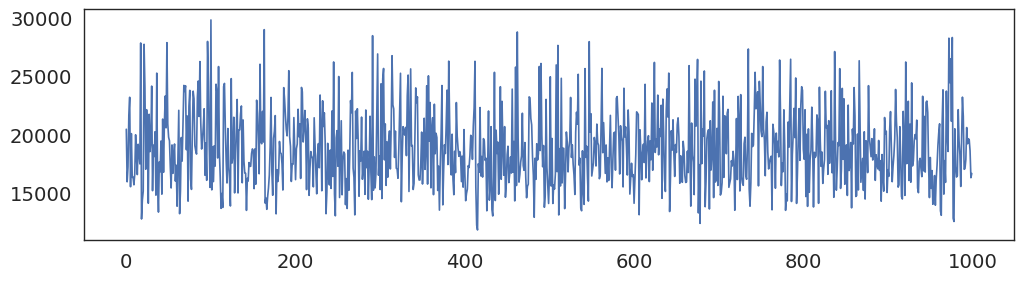

In [43]:
opts_regression = opts_regression | {'tau0': 1e-2, 'reduced': True, 'autoguide': 'mean-field'}
opts_fitting = opts_fitting | {'num_samples': 100, 'model_kwargs': {'batch_size': 128, 'with_hyperprior': True}}

dense = eqx.tree_inference(dense, value=True)

rng_key, key = random.split(rng_key)
output = run_inference(key, dense, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
results['dense']['Tiered-FF'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

In [50]:
opts_regression = {
    'regtype': 'multinomial',
    'gamma0': 0.1,
    'pruning': 'spike-and-slab',
    'posterior': 'normal',
    'optim_kwargs': {
        'learning_rate': 1e-2
    }
}

opts_fitting = {
    'num_epochs': num_epochs,
    'num_iters': max(500, num_iters - 10_000),
    'num_samples': 100,
    'model_kwargs': {
        'batch_size': 128, 
        'with_hyperprior': False,
    }
}

dense = eqx.tree_inference(dense, value=True)

rng_key, key = random.split(rng_key)
state, params = run_inference(key, dense, opts_regression, opts_fitting | {'warmup_iters': 5_000}, train_ds, test_ds, reg_model=BMRRegression)

100%|██████████| 10/10 [01:31<00:00,  9.13s/it, init loss: 22088.2305, avg. loss [epoch 10]: 14630.3994]


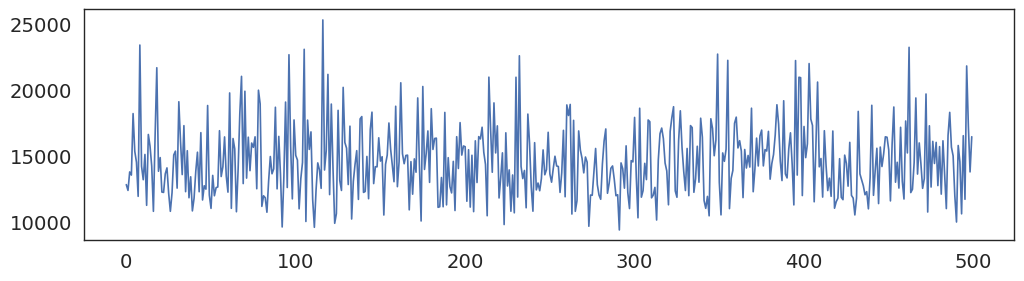

In [51]:
opts_fitting = opts_fitting | {'state': deepcopy(state), 'params': deepcopy(params)}
opts_regression = opts_regression | {'pruning': 'spike-and-slab'}

rng_key, key = random.split(rng_key)
output = run_inference(key, dense, opts_regression, opts_fitting, train_ds, test_ds, reg_model=BMRRegression)
results['dense']['BMR-S&S'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

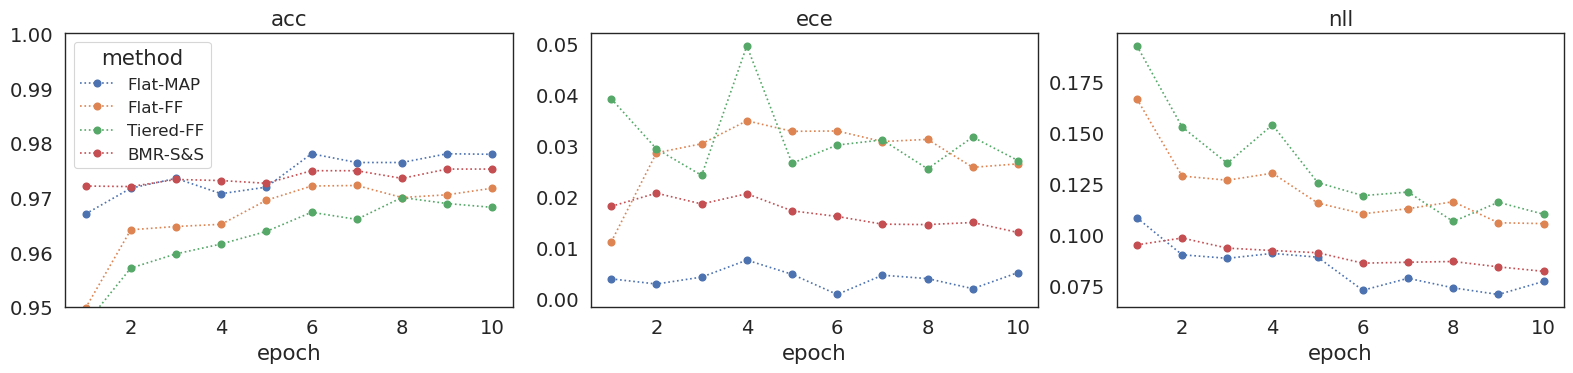

In [52]:
plot_performance( results['dense'], num_epochs );

### Vadam

In [8]:
import numpyro
import jax.tree_util as jtu
import numpyro.distributions as dist

def init_fn(rng_key, shape, radius=2.):
    return random.uniform(rng_key, shape=shape, minval=-radius, maxval=radius)

def get_linear_layers(nnet):
    is_linear = lambda x: isinstance(x, eqx.nn.Linear) or isinstance(x, eqx.nn.Conv) or isinstance(x, eqx.nn.LayerNorm)
    return [x for x in jtu.tree_leaves(nnet, is_leaf=is_linear) if is_linear(x)]

def register_network_params(nnet, mask, adaptive_scale=True):
    layers = get_linear_layers(nnet)
    L = len(layers)
    new_layers = []
    for l, layer in enumerate(layers):
        name = f'layer{l}'
        weight = layer.weight
        bias = layer.bias
        shape = weight.reshape(weight.shape[0], -1).shape
        if bias is not None:
            shape = (shape[0], shape[1] + 1)
        
        _scale = numpyro.param(f'{name}._scale', lambda key: init_fn(key, (1,), radius=1)) if adaptive_scale else 0.5
        _weights = nn.softplus(_scale) * numpyro.param(name, lambda key: init_fn(key, shape))

        _weights = jnp.where(mask[name], _weights, 0.) if mask is not None else _weights
        
        weight = _weights.reshape(weight.shape) if bias is None else _weights[..., :-1].reshape(weight.shape)
        bias = _weights[..., -1].reshape(bias.shape) if bias is not None else bias

        layer = eqx.tree_at(lambda x: (x.weight, x.bias), layer, (weight, bias))
        new_layers.append(layer)
    
    return eqx.tree_at(get_linear_layers, nnet, new_layers)

def likelihood(nnet, x, y, batch_size=None):
    N = x.shape[0]
    with numpyro.plate('data', N, subsample_size=batch_size):
        batch_x = numpyro.subsample(x, event_dim=3)
        key = random.PRNGKey(0) if numpyro.prng_key() is None else numpyro.prng_key()
        keys = random.split(key, batch_x.shape[0]) 
        logits = numpyro.deterministic('logits', vmap(nnet)(batch_x, key=keys) )

        batch_y = y if y is None else numpyro.subsample(y, event_dim=0)
        
        probs = numpyro.deterministic('probs', nn.softmax(logits, -1))
        with numpyro.handlers.scale(scale=1/N):
            numpyro.sample('obs', dist.Categorical(logits=logits), obs=batch_y)

def model(nnet, x, y=None, batch_size=None, mask=None, adaptive_scale=True):

    nnet = register_network_params(nnet, mask, adaptive_scale=adaptive_scale)
    likelihood(nnet, x, y, batch_size)

def guide(*args, **kwargs):
    pass

In [9]:
from numpyro.infer import SVI, Predictive, Trace_ELBO
from numpyro.optim import _NumPyroOptim
from optim import vadam, vadabelief
import optax

class VadamToNumpyro(object):

    def __init__(self, rng_key, t_lam, N):
        self.rng_key = rng_key
        self.t_lam = t_lam
        self.N = N

    def __call__(self, transformation) -> _NumPyroOptim:
        """
        This function produces a ``numpyro.optim._NumPyroOptim`` instance from an
        ``optax.GradientTransformation`` so that it can be used with
        ``numpyro.infer.svi.SVI``. It is a lightweight wrapper that recreates the
        ``(init_fn, update_fn, get_params_fn)`` interface defined by
        :mod:`jax.example_libraries.optimizers`.

        :param transformation: An ``optax.GradientTransformation`` instance to wrap.
        :return: An instance of ``numpyro.optim._NumPyroOptim`` wrapping the supplied
            Optax optimizer.
        """

        def init_fn(params):
            opt_state = transformation.init(params)
            return params, opt_state

        def update_fn(step, grads, state):
            params, opt_state = state
            updates, opt_state = transformation.update(grads, opt_state, params)
            updated_params = optax.apply_updates(params, updates)
            return updated_params, opt_state

        def get_params_fn(state):
            params, opt_state = state
            scales = jtu.tree_map( lambda x: jnp.sqrt(1/(N * (x + t_lam))), opt_state[0].s)
            keys = {}
            for name in scales:
                self.rng_key, keys[name] = random.split(rng_key)
            noise = jtu.tree_map( lambda x, key: x * random.normal(key, shape=x.shape), scales, keys )
            theta = jtu.tree_map(lambda x, e: x + e, params, noise)

            return theta

        return _NumPyroOptim(lambda x, y, z: (x, y, z), init_fn, update_fn, get_params_fn)

N = train_ds['image'].shape[0]
t_lam = 1 / N
t_init = 100 / N
learning_rate = 1e-2
loss = Trace_ELBO()

rng_key, key = random.split(rng_key)
_vadam_to_numpyro = VadamToNumpyro(key, t_lam, N)
optimizer1 = _vadam_to_numpyro( vadam(learning_rate=learning_rate, t_lam=t_lam, t_init=t_init) )
optimizer2 = _vadam_to_numpyro( vadabelief(learning_rate=learning_rate, t_lam=t_lam, t_init=t_init) )

In [10]:
from numpyro.optim import optax_to_numpyro

optimizer3 = optax_to_numpyro( optax.adam(learning_rate=1e-2) )
optimizer4 = optax_to_numpyro( optax.adamw(learning_rate=1e-2) )
optimizer5 = optax_to_numpyro( optax.adabelief(learning_rate=1e-2) )
optimizer6 = optax_to_numpyro( optax.lion(learning_rate=1e-3) )

In [12]:
from bmr4pml.inference import tests
from functools import partial

num_epochs = 20
batch_size = 128
num_iters = 500
kwargs = {
    'y': train_ds['label'],
    'batch_size': batch_size
}

args1 = (nnet, train_ds['image'])

det_nnet = eqx.tree_inference(nnet, value=True)
args2 = (det_nnet, train_ds['image'])

results_all = {}

def train_and_test(optim, rng_key, num_epochs, num_iters, *args, t_lam=None, prune=False, del_f=None, **kwargs):
    svi = SVI(model, guide, optim, loss)
    rng_key, key = random.split(rng_key)
    state = svi.init(key, *args, **kwargs)
    params = svi.get_params(state)
    mask = jtu.tree_map(lambda x: True, params)

    losses = []
    results = {'acc': [], 'ece': [], 'nll': [], 'lpd': []}

    for epoch in range(num_epochs):
        key, _key = random.split(key)
        kwargs = kwargs | {'mask': mask}
        svi_out = svi.run(
            _key, 
            num_iters,
            *args,
            progress_bar=False,
            init_state=state,
            init_params=params,
            ** kwargs 
        )

        state = svi_out.state
        params = svi_out.params
        losses.append( svi_out.losses )

        mdl = partial(numpyro.handlers.substitute(model, params), det_nnet, mask=mask)

        key, _key = random.split(key)
        smpl = Predictive(mdl, num_samples=1)(_key, test_ds['image'], y=test_ds['label'])
        smpl.pop('obs')
        
        output = tests(mdl, smpl, test_ds['image'], test_ds['label'])
        for label in results:
            results[label].append(output[label])
        
        if prune and epoch < num_epochs - 1:
            sigmas = jtu.tree_map( lambda x: 1 / jnp.sqrt( N * (x + t_lam) ), state.optim_state[1][1][0].s)
            mu = params
            mask = jtu.tree_map(lambda m, s, t: t * (del_f(m, s) <= 0), mu, sigmas, mask)

    results['losses'] = losses
    results['mask'] = mask

    return results, rng_key, params, state

In [78]:
results_all['adam'] = train_and_test(optimizer3, rng_key, num_epochs, num_iters, *args2, **kwargs);

In [79]:
results_all['adamw'] = train_and_test(optimizer4, rng_key, num_epochs, num_iters, *args2, **kwargs);

In [80]:
results_all['adabelief'] = train_and_test(optimizer5, rng_key, num_epochs, num_iters, *args2, **kwargs);

In [81]:
results_all['lion'] = train_and_test(optimizer6, rng_key, num_epochs, num_iters, *args2, **kwargs);

In [76]:
args = (det_nnet, train_ds['image'])
results_all['vadam'] = train_and_test(optimizer1, rng_key, num_epochs, num_iters, *args, **kwargs);

In [77]:
results_all['vadabelief'] = train_and_test(optimizer2, rng_key, num_epochs, num_iters, *args, **kwargs);

In [ ]:
def del_f(mu, sigma, sigma0=1.):
    return jnp.log(sigma0/sigma) - 0.5 * mu ** 2 / sigma ** 2

Df = partial(del_f, sigma0=jnp.sqrt(1/(t_lam * N)))

In [ ]:
results_all['bmr-vadam'] = train_and_test(
    optimizer1, rng_key, num_epochs, num_iters, *args2, t_lam=t_lam, prune=True, del_f=Df, **kwargs
);
print(jtu.tree_map(lambda m: m.mean(), results_all['bmr-vadam'][0]['mask']))


In [ ]:
results_all['bmr-vadabelief'] = train_and_test(
    optimizer2, rng_key, num_epochs, num_iters, *args2, t_lam=t_lam, prune=True, del_f=Df, **kwargs
);
print(jtu.tree_map(lambda m: m.mean(), results_all['bmr-vadabelief'][0]['mask']))

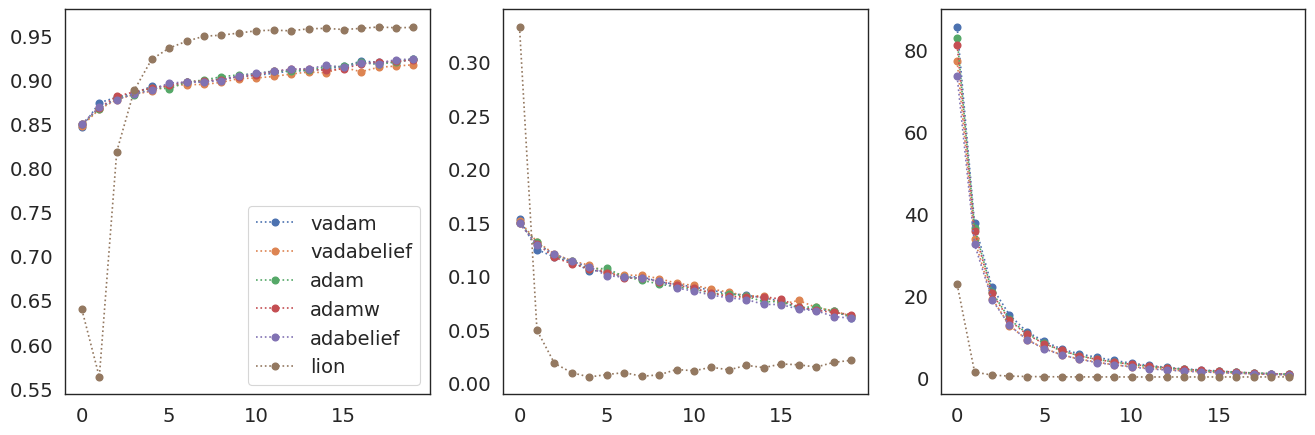

In [82]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for method in results_all:
    axes[0].plot(results_all[method][0]['acc'], 'o:', label=method)
    axes[1].plot(results_all[method][0]['ece'], 'o:')
    axes[2].plot(results_all[method][0]['nll'], 'o:')

axes[0].legend()

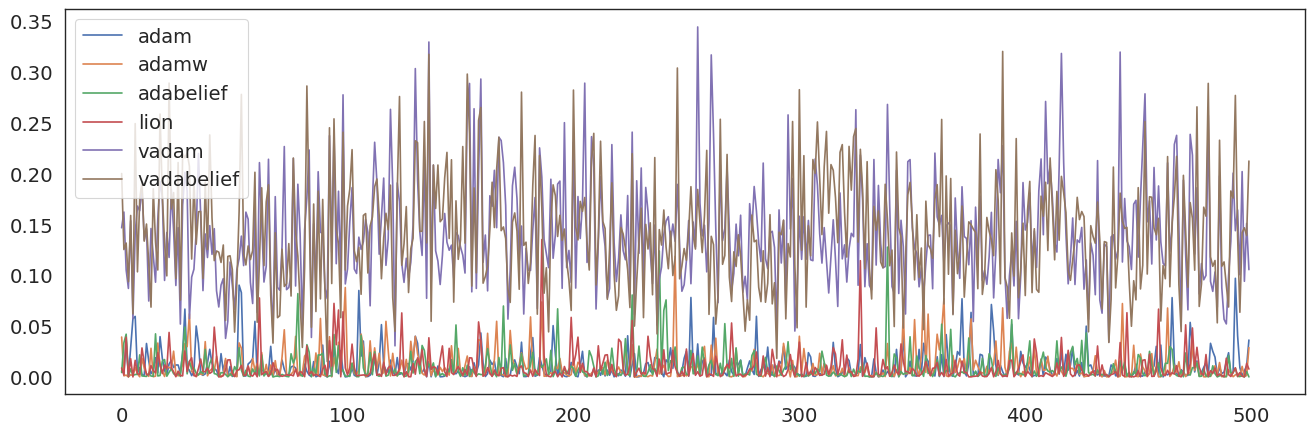

In [58]:
plt.figure(figsize=(16, 5))
for method in results_all:
    plt.plot( results_all[method][0]['losses'][-1], label=method)

plt.legend()

2023-09-20 14:31:29.525434: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reshape.1363 = u32[1]{0} reshape(u32[] %constant.1864)

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-09-20 14:31:29.525559: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.991053801s
Constant folding an instruction is taking > 1s:

  %reshape.1363 = u32[1]{0} reshape(u32[] %constant.1864)

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from ta

{'layer0': Array(0.5973758, dtype=float32), 'layer0._scale': Array(1., dtype=float32), 'layer1': Array(0.65287125, dtype=float32), 'layer1._scale': Array(1., dtype=float32), 'layer2': Array(0.6381188, dtype=float32), 'layer2._scale': Array(1., dtype=float32), 'layer3': Array(0.6980198, dtype=float32), 'layer3._scale': Array(1., dtype=float32)}


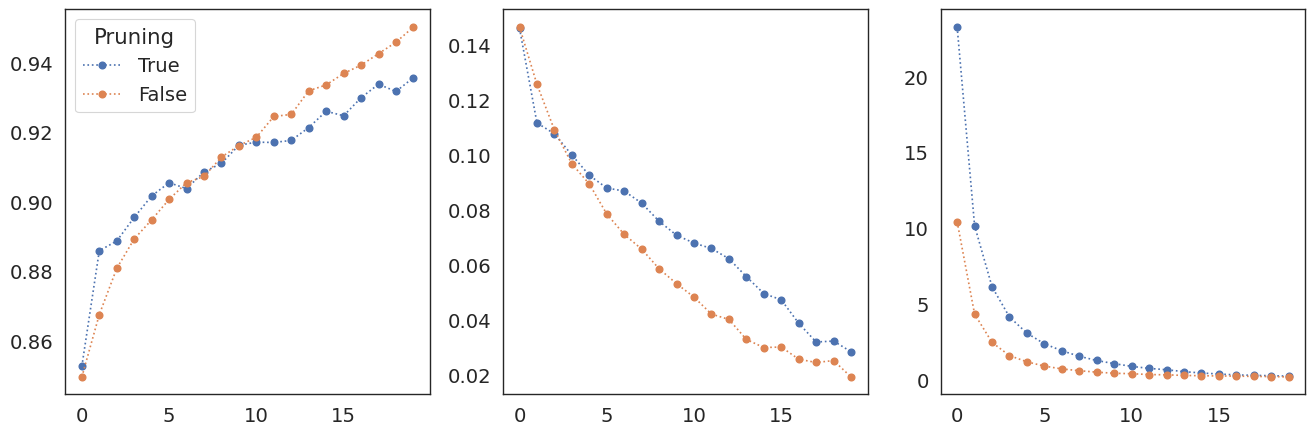

In [15]:
N = train_ds['image'].shape[0]
num_epochs = 20
t_init = 100 / N
learning_rate = 1e-2
loss = Trace_ELBO()
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for prune in [True, False]:
    for pi in [1]:
        t_lam = pi / N
        rng_key, key = random.split(rng_key)
        _vadam_to_numpyro = VadamToNumpyro(key, t_lam, N)
        optim = _vadam_to_numpyro( vadam(learning_rate=learning_rate, t_lam=t_lam, t_init=t_init) )

        Df = partial(del_f, sigma0=jnp.sqrt(1/pi))
        res, rng_key, parmas, state = train_and_test(optim, rng_key, num_epochs, num_iters, *args2, t_lam=t_lam, prune=prune, del_f=Df, **kwargs);
        if prune:
        axes[0].plot(res['acc'], 'o:', label=prune)
        axes[1].plot(res['ece'], 'o:')
        axes[2].plot(res['nll'], 'o:')

axes[0].legend(title='Pruning')

## LeNet

In [22]:
train_ds['image'] = jnp.pad(train_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))
test_ds['image'] = jnp.pad(test_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))

in_size = train_ds['image'].shape[-3:]

print(in_size)

(1, 32, 32)


In [26]:
num_epochs = 10
num_iters = 500

opts_regression = {
    'regtype': 'multinomial',
    'gamma0': 0.1,
    'autoguide': 'delta',
    'optim_kwargs': {
        'learning_rate': 1e-2
    }
}

opts_fitting = {
    'num_epochs': num_epochs,
    'num_iters': num_iters,
    'num_samples': 1,
    'model_kwargs': {
        'batch_size': 128, 
        'with_hyperprior': False
    }
}

rng_key, key = random.split(rng_key)
lenet = LeNet(in_size, activation=nn.swish, dropout_rate=0.5, key=key)

100%|██████████| 10/10 [03:29<00:00, 20.97s/it, init loss: 199330.5625, avg. loss [epoch 10]: 61622.0391]


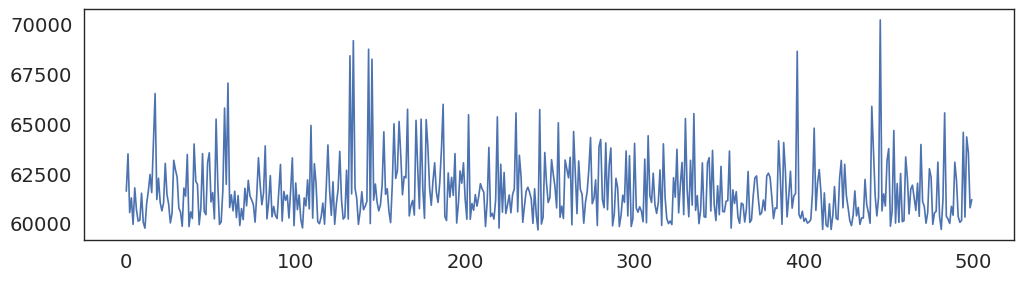

In [27]:
rng_key, key = random.split(rng_key)
output = run_inference(key, lenet, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
results['lenet']['Flat-MAP'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

In [ ]:
opts_regression = opts_regression | {'autoguide': 'mean-field', 'optim_kwargs': {'learning_rate': 1e-3}}
opts_fitting = opts_fitting | {'num_samples': 100}

lenet = eqx.tree_inference(lenet, value=True)

output = run_inference(key, lenet, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
results['lenet']['Flat-FF'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

100%|██████████| 5/5 [21:58<00:00, 263.73s/it, init loss: 429217.5000, avg. loss [epoch 5]: 23250.0039]


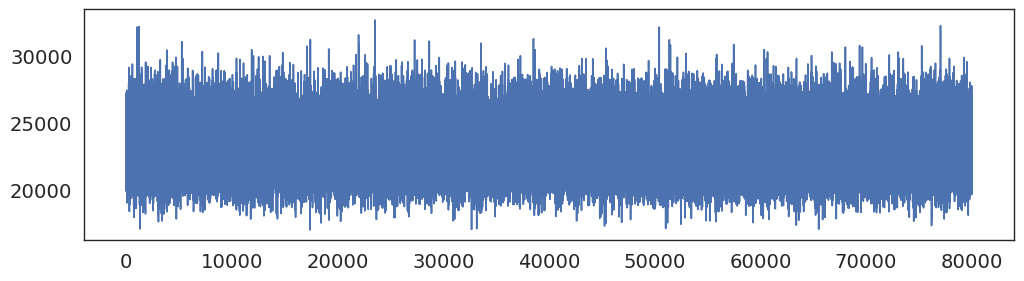

In [ ]:
opts_regression = opts_regression | {'autoguide': 'structured', 'optim_kwargs': {'learning_rate': 1e-3}}
opts_fitting = opts_fitting | {'num_samples': 100, 'model_kwargs': {'batch_size': 512, 'with_hyperprior': False}}

lenet = eqx.tree_inference(lenet, value=True)

output = run_inference(key, lenet, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
results['lenet']['Flat-STR'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

In [ ]:
opts_regression = opts_regression | {'tau0': 5 * 1e-2, 'reduced': True, 'autoguide': 'mean-field', 'optim_kwargs': {'learning_rate': 1e-3}}
opts_fitting = opts_fitting | {'num_samples': 100, 'model_kwargs': {'batch_size': 512, 'with_hyperprior': True}}

lenet = eqx.tree_inference(lenet, value=True)

output = run_inference(key, lenet, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
results['lenet']['Tiered-FF'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])lenet

 20%|██        | 1/5 [02:22<09:30, 142.73s/it, init loss: 297572.3438, avg. loss [epoch 1]: 33113.1523]

100%|██████████| 5/5 [24:44<00:00, 296.99s/it, init loss: 394434.7500, avg. loss [epoch 5]: 20140.5918]


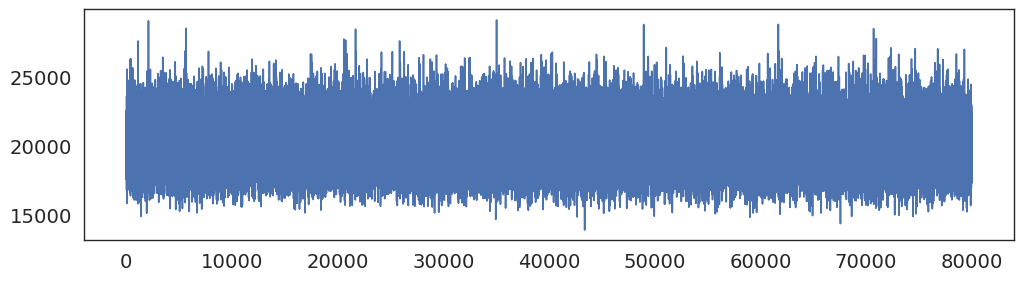

In [ ]:
opts_regression = opts_regression | {'tau0': 1e-1, 'reduced': True, 'autoguide': 'structured', 'optim_kwargs': {'learning_rate': 1e-3}}
opts_fitting = opts_fitting | {'num_samples': 100, 'model_kwargs': {'batch_size': 512, 'with_hyperprior': True}}

output = run_inference(key, lenet, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
results['lenet']['Tiered-STR'] = output
jnp.savez('tmp_results.npz', results=results)

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

In [ ]:
opts_regression = {
    'regtype': 'multinomial',
    'gamma0': 0.05,
    'pruning': 'spike-and-slab',
    'posterior': 'normal',
    'optim_kwargs': {
        'learning_rate': 1e-3
    }
}

opts_fitting = {
    'num_epochs': num_epochs,
    'num_iters': num_iters - 10_000,
    'num_samples': 100,
    'model_kwargs': {
        'batch_size': 512, 
        'with_hyperprior': False,
    }
}

lenet = eqx.tree_inference(lenet, value=True)

rng_key, key = random.split(rng_key)
state, params = run_inference(key, lenet, opts_regression, opts_fitting | {'warmup_iters': 400_000}, train_ds, test_ds, reg_model=BMRRegression)

In [ ]:
opts_fitting = opts_fitting | {'state': deepcopy(state), 'params': deepcopy(params)}
opts_regression = opts_regression | {'tau0': 5 * 1e-2, 'reduced': True,  'pruning': 'regularised-horseshoe'}
opts_fitting = opts_fitting | {'pruning_kwargs': {'delta': 1e-5}}

rng_key, key = random.split(rng_key)
output = run_inference(key, lenet, opts_regression, opts_fitting, train_ds, test_ds, reg_model=BMRRegression)
results['lenet']['BMR-RHS'] = output
print(output['zip'])
print(output['acc'])

plt.figure( figsize=(12, 3) )
plt.plot( output['losses'][-1] )

100%|██████████| 5/5 [08:04<00:00, 96.84s/it, init loss: 28764.2754, avg. loss [epoch 5]: 25343.2930]


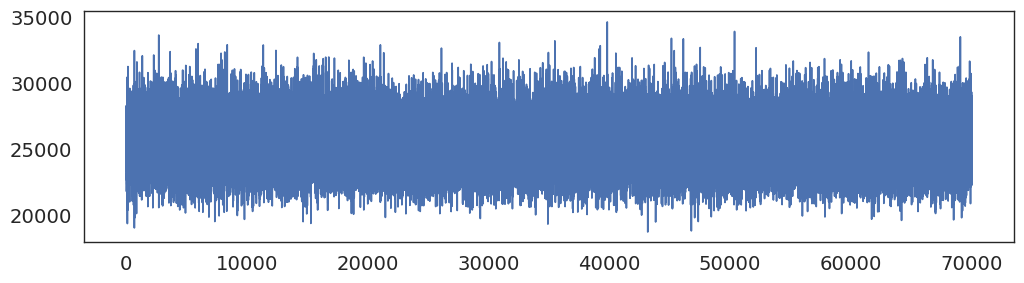

In [ ]:
opts_fitting = opts_fitting | {'state': deepcopy(state), 'params': deepcopy(params)}
opts_regression = opts_regression | {'pruning': 'spike-and-slab'}

rng_key, key = random.split(rng_key)
output = run_inference(key, lenet, opts_regression, opts_fitting, train_ds, test_ds, reg_model=BMRRegression)
results['lenet']['BMR-S&S'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

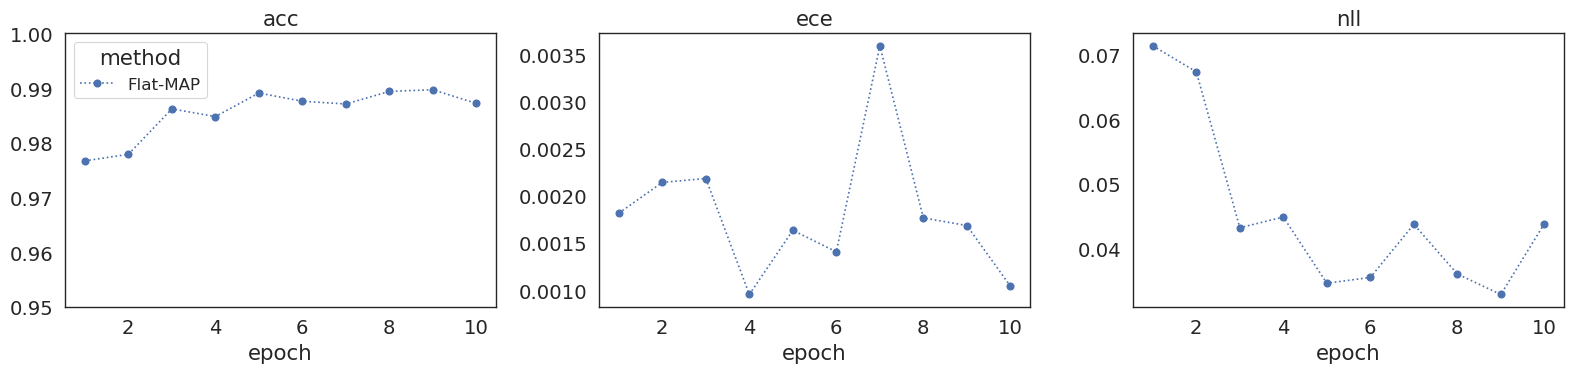

In [28]:
plot_performance( results['lenet'], num_epochs );

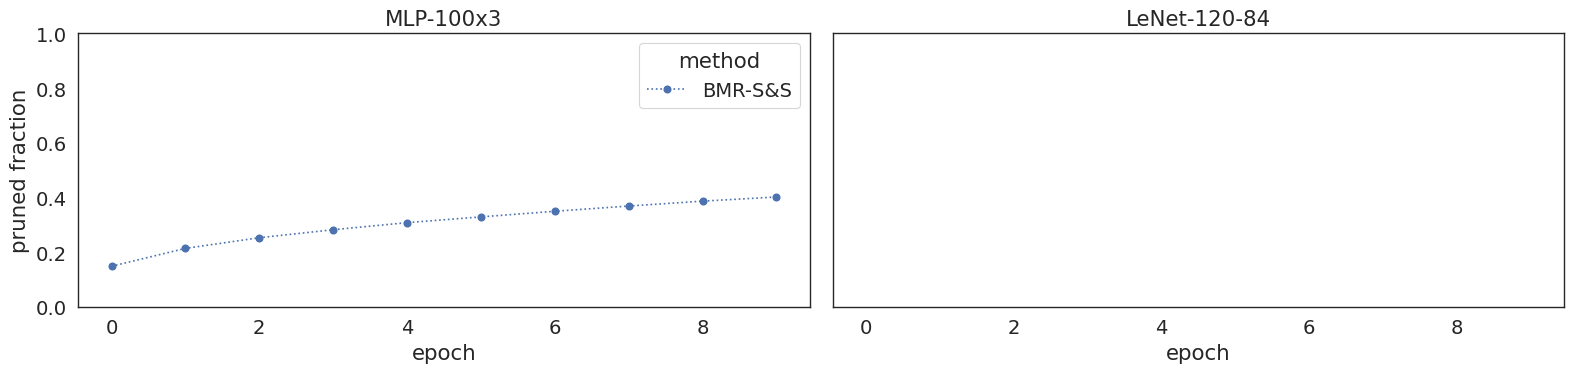

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=True, sharey=True)

for i, label in enumerate(['dense', 'lenet']):
    for key in results[label]:
        vals = results[label][key]
        try:
            axes[i].plot(range(num_epochs), vals['zip'], 'o:', label=key)
        except:
            pass

for ax in axes:
    ax.set_xlabel('epoch')

axes[0].set_ylabel('pruned fraction')
axes[0].set_ylim([0, 1])
axes[0].set_title('MLP-100x3')
axes[1].set_title('LeNet-120-84')

axes[0].legend(title='method')
fig.tight_layout()